In [1]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [2]:
# ================================
# Imports
# ================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from google.colab import drive

# ================================
# Drive
# ================================
drive.mount("/content/drive")

# ================================
# Paths
# ================================
BASE_DIR = "/content/drive/MyDrive/Amazon project/processed_images"
COLOR_FILE = os.path.join(BASE_DIR, "left_final.png")
DISPARITY_FILE = os.path.join(BASE_DIR, "disparity_final.npy")


Mounted at /content/drive


In [3]:

# ================================
# Camera parameters
# ================================
K = np.array([
    [1.17304916e+03, 0.0, 5.54205309e+02],
    [0.0, 1.17303248e+03, 7.34732022e+02],
    [0.0, 0.0, 1.0]
])

FX, FY = K[0,0], K[1,1]
CX, CY = K[0,2], K[1,2]

BASELINE = 0.05
MAX_DEPTH = 3.0

# ================================
# Disparity → Depth
# ================================
def disparity_to_depth(disp):
    depth = np.zeros_like(disp, np.float32)
    valid = disp > 3.0
    depth[valid] = (FX * BASELINE) / disp[valid]
    depth[(depth <= 0) | (depth > MAX_DEPTH)] = 0
    return depth

In [4]:


# ================================
# Guided Filter (pure)
# ================================
def guided_filter(guide, src, r=9, eps=1e-4):
    mean_g = cv2.boxFilter(guide, -1, (r,r))
    mean_s = cv2.boxFilter(src,   -1, (r,r))
    corr_gg = cv2.boxFilter(guide*guide, -1, (r,r))
    corr_gs = cv2.boxFilter(guide*src,   -1, (r,r))
    var_g = corr_gg - mean_g*mean_g
    cov_gs = corr_gs - mean_g*mean_s
    a = cov_gs / (var_g + eps)
    b = mean_s - a*mean_g
    mean_a = cv2.boxFilter(a, -1, (r,r))
    mean_b = cv2.boxFilter(b, -1, (r,r))
    return mean_a*guide + mean_b

In [5]:

# ================================
# Hole filling
# ================================
def fill_depth(left, depth):
    hole = (depth <= 0).astype(np.uint8) * 255
    depth_norm = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_inpaint = cv2.inpaint(depth_norm, hole, 5, cv2.INPAINT_TELEA).astype(np.float32)

    gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    guided = guided_filter(gray, depth_inpaint)

    guided[hole == 0] = depth_norm[hole == 0]
    guided = guided / 255.0 * MAX_DEPTH
    return guided

In [6]:
# ================================
# Plane refinement (observed plane)
# ================================
def plane_refine(depth):
    ys, xs = np.where(depth > 0)
    zs = depth[ys, xs]

    X = (xs - CX) * zs / FX
    Y = (ys - CY) * zs / FY
    Z = zs

    pts = np.stack([X, Y, Z], axis=1)
    pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pts))

    plane_model, inliers = pcd.segment_plane(
        distance_threshold=0.01,
        ransac_n=3,
        num_iterations=2000
    )

    a,b,c,d = plane_model
    pts_in = pts[inliers]
    dist = (a*pts_in[:,0] + b*pts_in[:,1] + c*pts_in[:,2] + d)
    pts_proj = pts_in - np.outer(dist, [a,b,c])

    depth_new = depth.copy()
    depth_new[ys[inliers], xs[inliers]] = pts_proj[:,2]
    return depth_new


In [7]:
# ================================
# Tabletop completion (核心)
# ================================
def complete_tabletop(depth):
    h, w = depth.shape
    depth_new = depth.copy()

    ys, xs = np.where(depth > 0)
    zs = depth[ys, xs]

    X = (xs - CX) * zs / FX
    Y = (ys - CY) * zs / FY
    Z = zs
    pts = np.stack([X, Y, Z], axis=1)

    pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pts))

    plane_model, inliers = pcd.segment_plane(
        distance_threshold=0.05,
        ransac_n=3,
        num_iterations=3000
    )

    a,b,c,d = plane_model

    # 側面（ほぼ垂直）だけ使う
    if abs(b) > 0.6:
        print("⚠ 側面平面が検出されません")
        return depth_new

    inliers = np.array(inliers)
    xs_i = xs[inliers]
    ys_i = ys[inliers]
    zs_i = zs[inliers]

    tabletop_z = np.min(zs_i)      # 天板高さ
    y_start = np.max(ys_i)         # 側面より奥だけ
    x_min, x_max = np.min(xs_i), np.max(xs_i)

    for y in range(y_start, h):
        for x in range(x_min, x_max):
            if depth_new[y, x] == 0:
                depth_new[y, x] = tabletop_z

    return depth_new


In [8]:

# ================================
# Tabletop completion (奥方向補完)
# ================================
def complete_tabletop(depth):
    depth_new = depth.copy()
    h, w = depth.shape

    # 横方向スキャンで手前端を検出
    boundary_z = np.zeros(w, np.float32)
    for x in range(w):
        col = depth[:, x]
        valid = col[col > 0]
        if len(valid) > 0:
            boundary_z[x] = np.min(valid)
        else:
            boundary_z[x] = 0  # 欠損列

    # 平滑化（滑らかな境界線）
    boundary_z_smooth = cv2.GaussianBlur(boundary_z, (11,1), 0)

    # 奥方向に向かって補完
    for y in range(h):
        for x in range(w):
            if depth_new[y, x] == 0:
                depth_new[y, x] = boundary_z_smooth[x]

    return depth_new

In [9]:
# ================================
# Main
# ================================
left = cv2.imread(COLOR_FILE)
disp = np.load(DISPARITY_FILE).astype(np.float32)
if disp.ndim == 3:
    disp = disp[:,:,0]

depth_raw = disparity_to_depth(disp)
depth_filled = fill_depth(left, depth_raw)
depth_plane = plane_refine(depth_filled)
depth_table = complete_tabletop(depth_plane)



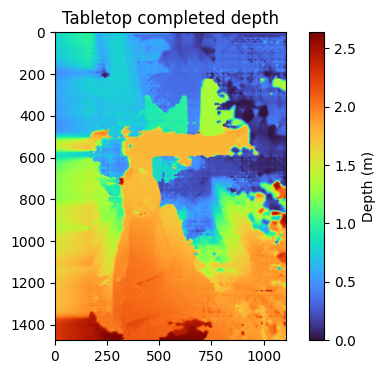

In [10]:
# ================================
# Visualization
# ================================
plt.figure(figsize=(6,4))
plt.imshow(MAX_DEPTH - depth_table, cmap="turbo")
plt.colorbar(label="Depth (m)")
plt.title("Tabletop completed depth")
plt.show()

In [11]:
# ================================
# Point Cloud
# ================================
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(cv2.cvtColor(left, cv2.COLOR_BGR2RGB)),
    o3d.geometry.Image(depth_table.astype(np.float32)),
    depth_scale=1.0,
    depth_trunc=MAX_DEPTH,
    convert_rgb_to_intensity=False
)

intrinsic = o3d.camera.PinholeCameraIntrinsic(
    left.shape[1], left.shape[0], FX, FY, CX, CY
)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])

ply_path = os.path.join(BASE_DIR, "reconstruction_tabletop_completed.ply")
o3d.io.write_point_cloud(ply_path, pcd)

print("天板補完付き点群 完了:", ply_path)

✅ 天板補完付き点群 完了: /content/drive/MyDrive/Amazon project/processed_images/reconstruction_tabletop_completed.ply


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


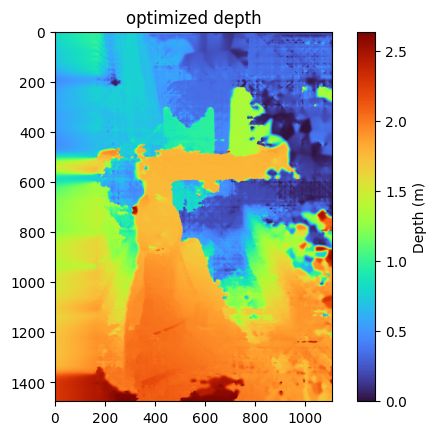

✅ Matrix-based depth optimization 完了


In [12]:
# ================================
# Imports
# ================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import scipy.sparse as sp
# import scipy.sparse.linalg as spla
import open3d as o3d
from google.colab import drive

# ================================
# Drive
# ================================
drive.mount("/content/drive")

# ================================
# Paths
# ================================
BASE_DIR = "/content/drive/MyDrive/Amazon project/processed_images"
COLOR_FILE = os.path.join(BASE_DIR, "left_final.png")
DISPARITY_FILE = os.path.join(BASE_DIR, "disparity_final.npy")

# ================================
# Camera parameters
# ================================
K = np.array([
    [1.15994113e+03, 0.00000000e+00, 5.46000399e+02],
 [0.00000000e+00, 1.15929016e+03, 7.32384585e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]
, dtype=np.float64)

FX, FY = K[0,0], K[1,1]
CX, CY = K[0,2], K[1,2]

BASELINE = 0.05
MAX_DEPTH = 3.0

# ================================
# Disparity → Depth
# ================================
def disparity_to_depth(disp):
    depth = np.zeros_like(disp, np.float32)
    valid = disp > 3.0
    depth[valid] = (FX * BASELINE) / disp[valid]
    depth[(depth <= 0) | (depth > MAX_DEPTH)] = 0
    return depth


# ================================
# Main
# ================================
left = cv2.imread(COLOR_FILE)
disp = np.load(DISPARITY_FILE).astype(np.float32)
if disp.ndim == 3:
    disp = disp[:,:,0]

depth_raw = disparity_to_depth(disp)


depth_opt = depth_raw


# ---- tabletop mask (simple heuristic) ----
grad = cv2.Sobel(depth_raw, cv2.CV_32F, 0, 1, ksize=3)
mask_plane = (np.abs(grad) < 0.01) & (depth_raw > 0)

# depth_opt = optimize_depth_matrix(depth_raw, mask_plane)
depth_opt = depth_plane


# ================================
# Visualization
# ================================
plt.imshow(MAX_DEPTH - depth_opt, cmap="turbo")
plt.colorbar(label="Depth (m)")
plt.title("optimized depth")
plt.show()

# ================================
# Point Cloud
# ================================
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(cv2.cvtColor(left, cv2.COLOR_BGR2RGB)),
    o3d.geometry.Image(depth_opt.astype(np.float32)),
    depth_scale=1.0,
    depth_trunc=MAX_DEPTH,
    convert_rgb_to_intensity=False
)

intrinsic = o3d.camera.PinholeCameraIntrinsic(
    left.shape[1], left.shape[0], FX, FY, CX, CY
)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])

ply_path = os.path.join(BASE_DIR, "reconstruction_optimized.ply")
o3d.io.write_point_cloud(ply_path, pcd)

print("depth optimization 完了")
